## This is a notebook to train a Physics Informed Neural Network on Burger's equation

The one dimensional Burger's equation is given by:
$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}; \;\;\; x \in [-1, 1], t \in [0,1]$$

This equation can be solved numerically with appropriate initial and boundary conditions. In this notebook, a physics informed neural network is trained to learn the solution of the Burger's equation.

### Import necessary tools
In the following cell we import the necessary libraries to set up the environment to run the code.

In [1]:
# Import necessary libraries
import torch 
import torch.nn as nn
import numpy as np
import scipy
from pyDOE import lhs
import time 
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

### Define the neural network
Once the libraries are loaded, we build the neural networks. We build two neural networks, one (`net_u`) for predicting the solution $u$ and the other (`net_f`) for predicting the residual of the governing equation $f(u)$. The number of layers and neurons in each layer is taken as a list input to construct the network `net_u`. The residuals in the network `net_f` are computed using the derivatives of the solutions computing using automatic differentiation.  

In [2]:
# Define a network for predicting u

layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

layer_list = []
for l in range(len(layers)-1):
    layer_list.append(nn.Linear(layers[l],layers[l+1]))
    layer_list.append(nn.Tanh())

    
net_u = nn.Sequential(*layer_list)

# Define a network for predicting f

def net_f(x, t, nu):
    x.requires_grad = True
    t.requires_grad = True
    u = net_u(torch.cat([x,t],1))
    u_t = torch.autograd.grad(u, t, create_graph=True, grad_outputs=torch.ones_like(u), 
                     allow_unused=True)[0]
    u_x = torch.autograd.grad(u, x, create_graph=True,
                     grad_outputs=torch.ones_like(u), 
                     allow_unused=True)[0]
    u_xx = torch.autograd.grad(u_x, x, create_graph=True,
                     grad_outputs=torch.ones_like(u), 
                     allow_unused=True)[0]
    f = u_t + u * u_x - nu * u_xx
    return f

### Define functions to train and predict
Next, we define functions to train and predict the neural networks. The train function takes the discretized domain, the initial and boundary conditions along with the optimizer as input. The function computes the loss and backpropagate the gradients to learn the parameters of the network. The predict function takes the test location in the domain and the time to predict the solution.

In [3]:
# Functions to train and predict

def train_step( X_u_train_t, u_train_t, X_f_train_t, opt, nu):
    x_u = X_u_train_t[:,0:1]
    t_u = X_u_train_t[:,1:2]
    x_f = X_f_train_t[:,0:1]
    t_f = X_f_train_t[:,1:2]
    opt.zero_grad()
    u_nn = net_u(torch.cat([x_u, t_u],1))
    f_nn = net_f(x_f,t_f, nu)
    loss =  torch.mean(torch.square(u_nn - u_train_t)) + torch.mean(torch.square(f_nn))
    loss.backward()
    opt.step() 
    return loss

def predict(X_star_tf):
    x_star = X_star_tf[:,0:1]
    t_star = X_star_tf[:,1:2]
    u_pred = net_u(torch.cat([x_star, t_star],1))
    return u_pred

### Define the data, domain and boundary conditions
We now define the parameters for the Burger's equations such as viscosity and number of discretizations. We also specify the maximum number of epochs. In the following cells we load and process the data, define the domain and boundary conditions for the Burger's equation.  

In [4]:
# Parameter definitions

nu = 0.01/np.pi # Viscosity
N_u = 100 # Number of Initial and Boundary data points
N_f = 10000 # Number of residual point
Nmax=  50000 # Number of epochs


In [5]:
# Load and process data

data = scipy.io.loadmat('./burgers_shock.mat')

t = data['t'].flatten()[:,None] # The temporal domain is discretized between 0 to 1 in 100 points
x = data['x'].flatten()[:,None] # The spatial domain is discretized between -1 to 1 in 256 points
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]

In [6]:
# Define the domain and boundary conditions

# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0)

# Initial Condition
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T

# Boundary condition -1
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]

# Boundary condition 1
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

In [7]:
# Generate training data

X_u_train = np.vstack([xx1, xx2, xx3])
u_train = np.vstack([uu1, uu2, uu3])

X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)

X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

X_u_train_t = torch.tensor(X_u_train, dtype=torch.float32)
u_train_t =   torch.tensor(u_train, dtype=torch.float32)
X_f_train_t = torch.tensor(X_f_train, dtype=torch.float32)

### Train the model
We define an optimizer to perform backpropagation to learn the weights. We also define parameters related to the optimizers such as the learning rate.

In [8]:
# Define optimizer 
lr = 1e-4
optimizer = torch.optim.Adam(net_u.parameters(),lr=lr)

We train the model with all the settings we defined before and compute the losses. For convenience, the model as already been trained and its weights saved. The code below was used to train the model.

``` python

start_time = time.time()
n=0
loss = []
while n <= Nmax:
    loss_= train_step(X_u_train_t, u_train_t, X_f_train_t, optimizer, nu)
    loss.append(loss_.detach().numpy())
    print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

checkpt = {'model':net_u.state_dict(),
            'Train_loss':loss,    
            }
torch.save(checkpt, 'Burgers_results.pt')
```

### Predict solutions and visualize results
Finally we load the model, predict the solution of the Burger's equation and compute the errors.

In [9]:
ckpt = torch.load('Burgers_results.pt')
net_u.load_state_dict(ckpt['model'])
loss = ckpt['Train_loss']

In [10]:
# predict and compute errors

X_star_t = torch.tensor(X_star, dtype=torch.float32)
u_pred = predict(X_star_t)
u_pred = u_pred.detach().numpy()
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' %(error_u))
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = 100* np.linalg.norm(Exact - U_pred) / np.linalg.norm(U_pred)

Error u: 3.390147e-02


We visulaize the results of our training by plotting the evolution of the loss with respect to the epochs and comparing the predictions by the neural network model with the ground truth.

Loss convergence


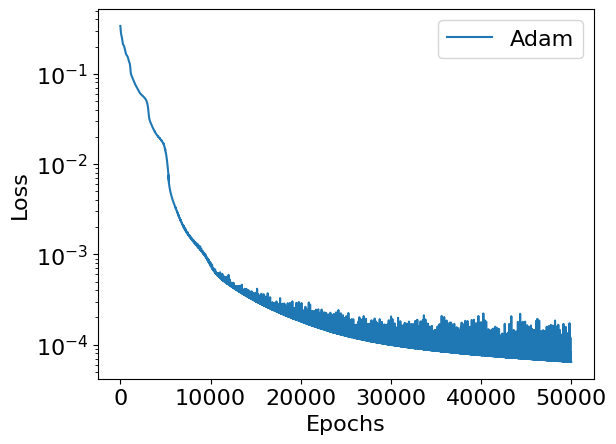

In [11]:
# plot the results
plt.rcParams.update({'font.size': 16})
print('Loss convergence')
loss = np.array(loss)
range_adam = np.arange(0, Nmax+1)
plt.semilogy(range_adam, loss, label='Adam')
#plt.plot(epochs, loss, label = 'adam optimizer')
#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

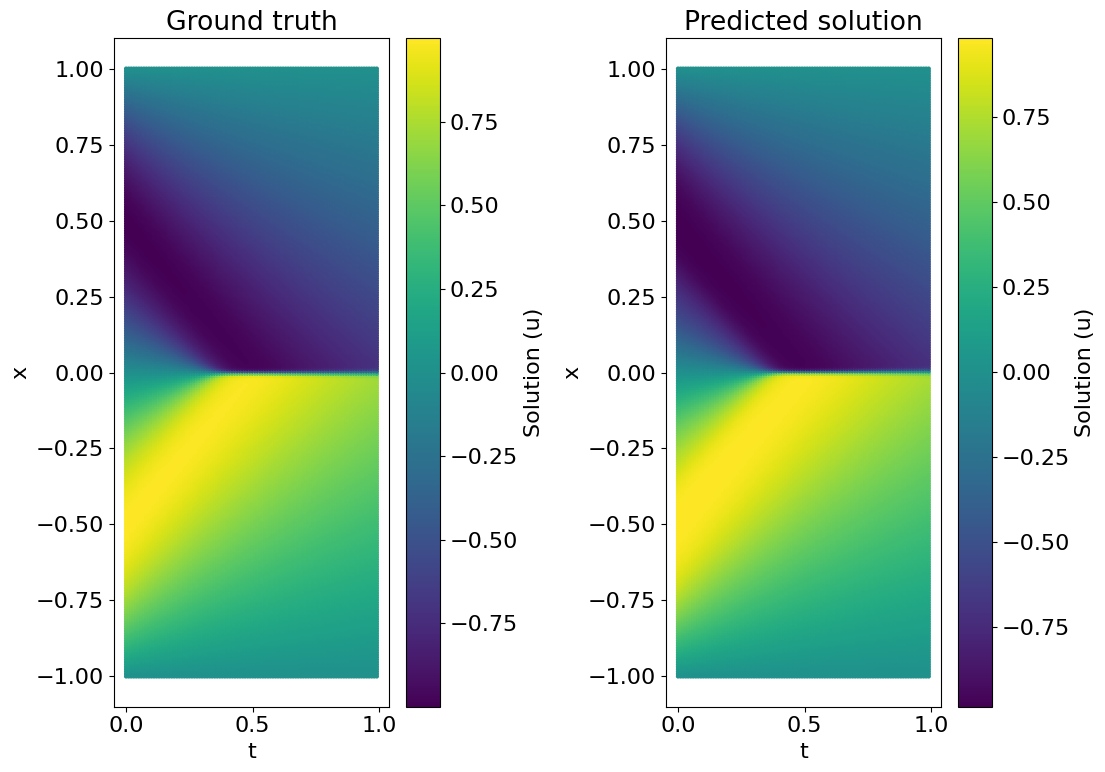

In [12]:

plt.figure(figsize=(16, 8))
plt.subplot(1,3,1)
plt.scatter(X_star[:,1:2], X_star[:,0:1], c = u_star, cmap = 'viridis', s = 5)
plt.colorbar(label='Solution (u)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Ground truth')

plt.subplot(1,3,2)
plt.scatter(X_star[:,1:2], X_star[:,0:1], c = U_pred, cmap = 'viridis', s = 5)
plt.colorbar(label='Solution (u)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Predicted solution')

plt.tight_layout()
plt.savefig('Burgers_result.png')
plt.show()
